# Inverse Kinematics for a robot arm in Mujoco

In [1]:
import numpy as np
import mujoco
import mujoco.viewer as viewer
import mediapy as media

## Load Model

In [2]:
#Load model
xml = "/home/iitgn-robotics/Saniya/inversekinematics-numerical/mujoco-3.1.6/model/universal_robots_ur5e/scene.xml" # add your path
model = mujoco.MjModel.from_xml_path(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

## Setup Camera

In [3]:
#Make a new camera, move it to a closer distance.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 1

## Get a test point

Results
initial point => [-0.134  0.817  0.063]
Desire point => [0.492 0.134 0.588] 



Initial position,Desire end effector position

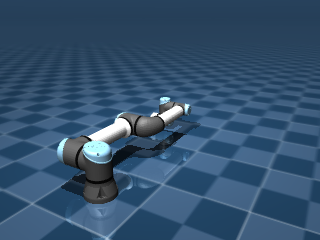
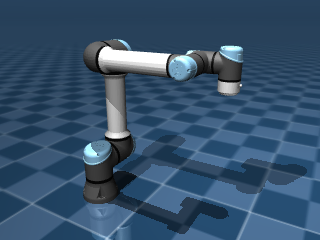

In [4]:
#Put a position of the joints to get a test point
pi = np.pi
data.qpos = [3*pi/2, -pi/2, pi/2, 3*pi/2, 3*pi/2, 0]

#Inititial joint position
qpos0 = data.qpos.copy()

#Step the simulation.
mujoco.mj_forward(model, data)

#Use the last piece as an "end effector" to get a test point in cartesian coordinates
target = data.body('wrist_3_link').xpos.copy()

#Plot results
print("Results")
mujoco.mj_resetDataKeyframe(model, data, 1)
mujoco.mj_forward(model, data)
init_point = data.body('wrist_3_link').xpos.copy()
renderer.update_scene(data, camera)
target_plot = renderer.render()

data.qpos = qpos0
mujoco.mj_forward(model, data)
result_point = data.body('wrist_3_link').xpos.copy()
renderer.update_scene(data, camera)
result_plot = renderer.render()

print("initial point =>", init_point)
print("Desire point =>", result_point, "\n")

images = {
    'Initial position': target_plot,
    ' Desire end effector position': result_plot,
}

media.show_images(images)

## Find Joint Limits

In [5]:
#get the name of the joints and its limits
for j in range(len(data.qpos)):
    print("name part =>", data.jnt(j).name, "\n", 
          "limit =>", model.jnt_range[j], "\n")

name part => shoulder_pan_joint 
 limit => [-6.28319  6.28319] 

name part => shoulder_lift_joint 
 limit => [-6.28319  6.28319] 

name part => elbow_joint 
 limit => [-3.1415  3.1415] 

name part => wrist_1_joint 
 limit => [-6.28319  6.28319] 

name part => wrist_2_joint 
 limit => [-6.28319  6.28319] 

name part => wrist_3_joint 
 limit => [-6.28319  6.28319] 



## Gradient Descent IK

Results
testing point => [0.492 0.134 0.588]
Gradient Descent result => [0.49680124 0.13197328 0.59702751] 



Testing point,Gradient Descent result

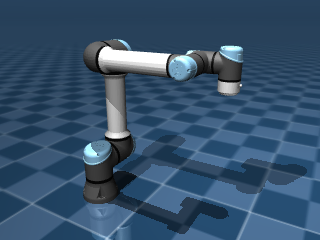
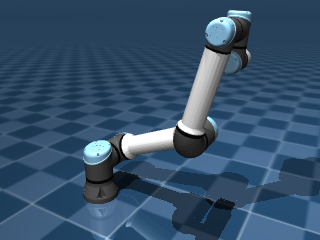

In [6]:
class GradientDescentIK:
    
    def __init__(self, model, data, step_size, tol, alpha, jacp, jacr):
        self.model = model
        self.data = data
        self.step_size = step_size
        self.tol = tol
        self.alpha = alpha
        self.jacp = jacp
        self.jacr = jacr
    
    def check_joint_limits(self, q):
        """Check if the joints is under or above its limits"""
        for i in range(len(q)):
            q[i] = max(self.model.jnt_range[i][0], min(q[i], self.model.jnt_range[i][1]))

    #Gradient Descent pseudocode implementation
    def calculate(self, goal, init_q, body_id):
        """Calculate the desire joints angles for goal"""
        self.data.qpos = init_q
        mujoco.mj_forward(self.model, self.data)
        current_pose = self.data.body(body_id).xpos
        error = np.subtract(goal, current_pose)

        while (np.linalg.norm(error) >= self.tol):
            #calculate jacobian
            mujoco.mj_jac(self.model, self.data, self.jacp, self.jacr, goal, body_id)
            #calculate gradient
            grad = self.alpha * self.jacp.T @ error
            #compute next step
            self.data.qpos += self.step_size * grad
            #check joint limits
            self.check_joint_limits(self.data.qpos)
            #compute forward kinematics
            mujoco.mj_forward(self.model, self.data) 
            #calculate new error
            error = np.subtract(goal, self.data.body(body_id).xpos)        

    
#Init variables.
body_id = model.body('wrist_3_link').id
jacp = np.zeros((3, model.nv)) #translation jacobian
jacr = np.zeros((3, model.nv)) #rotational jacobian
goal = [0.49, 0.13, 0.59]
step_size = 0.5
tol = 0.01
alpha = 0.5
init_q = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

ik = GradientDescentIK(model, data, step_size, tol, alpha, jacp, jacr)

#Get desire point
mujoco.mj_resetDataKeyframe(model, data, 1) #reset qpos to initial value
ik.calculate(goal, init_q, body_id) #calculate the q angles

result = data.qpos.copy()

#Plot results
print("Results")
data.qpos = qpos0
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera)
target_plot = renderer.render()

data.qpos = result
mujoco.mj_forward(model, data)
result_point = data.body('wrist_3_link').xpos
renderer.update_scene(data, camera)
result_plot = renderer.render()

print("testing point =>", target)
print("Gradient Descent result =>", result_point, "\n")

images = {
    'Testing point': target_plot,
    'Gradient Descent result': result_plot,
}

media.show_images(images)

## Gauss-newton IK

Results
testing point => [0.492 0.134 0.588]
Gauss-Newton result => [0.49649825 0.13125565 0.59382695] 



Testing point,Gauss-Newton result

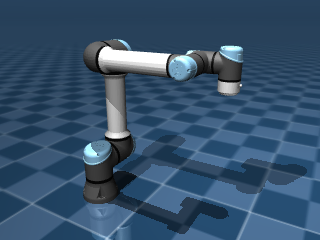
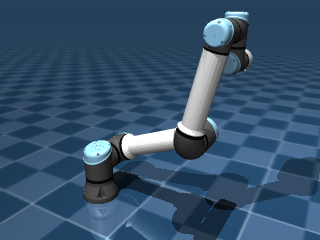

In [7]:
class GaussNewtonIK:
    
    def __init__(self, model, data, step_size, tol, alpha, jacp, jacr):
        self.model = model
        self.data = data
        self.step_size = step_size
        self.tol = tol
        self.alpha = alpha
        self.jacp = jacp
        self.jacr = jacr
    
    def check_joint_limits(self, q):
        """Check if the joints is under or above its limits"""
        for i in range(len(q)):
            q[i] = max(self.model.jnt_range[i][0], min(q[i], self.model.jnt_range[i][1]))
    
    #Gauss-Newton pseudocode implementation
    def calculate(self, goal, init_q, body_id):
        """Calculate the desire joints angles for goal"""
        self.data.qpos = init_q
        mujoco.mj_forward(self.model, self.data)
        current_pose = self.data.body(body_id).xpos
        error = np.subtract(goal, current_pose)

        while (np.linalg.norm(error) >= self.tol):
            #calculate jacobian
            mujoco.mj_jac(self.model, self.data, self.jacp, self.jacr, goal, body_id)
            #calculate delta of joint q
            product = self.jacp.T @ self.jacp
            
            if np.isclose(np.linalg.det(product), 0):
                j_inv = np.linalg.pinv(product) @ self.jacp.T
            else:
                j_inv = np.linalg.inv(product) @ self.jacp.T
            
            delta_q = j_inv @ error
            #compute next step
            self.data.qpos += self.step_size * delta_q
            #check limits
            self.check_joint_limits(self.data.qpos)
            #compute forward kinematics
            mujoco.mj_forward(self.model, self.data) 
            #calculate new error
            error = np.subtract(goal, self.data.body(body_id).xpos)        

    
#Init variables.
body_id = model.body('wrist_3_link').id
jacp = np.zeros((3, model.nv)) #translation jacobian
jacr = np.zeros((3, model.nv)) #rotational jacobian
goal = [0.49, 0.13, 0.59]
step_size = 0.5
tol = 0.01
alpha = 0.5
init_q = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

ik = GaussNewtonIK(model, data, step_size, tol, alpha, jacp, jacr)

#Get desire point
mujoco.mj_resetDataKeyframe(model, data, 1) #reset qpos to initial value
ik.calculate(goal, init_q, body_id) #calculate the qpos

result = data.qpos.copy()

#Plot results
print("Results")
data.qpos = qpos0
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera)
target_plot = renderer.render()

data.qpos = result
mujoco.mj_forward(model, data)
result_point = data.body('wrist_3_link').xpos
renderer.update_scene(data, camera)
result_plot = renderer.render()

print("testing point =>", target)
print("Gauss-Newton result =>", result_point, "\n")

images = {
    'Testing point': target_plot,
    'Gauss-Newton result': result_plot,
}

media.show_images(images)

## Levenberg-Marquardt IK

Results
testing point => [0.492 0.134 0.588]
Levenberg-Marquardt result => [0.49674303 0.13194421 0.59694655] 



Testing point,Levenberg-Marquardt result

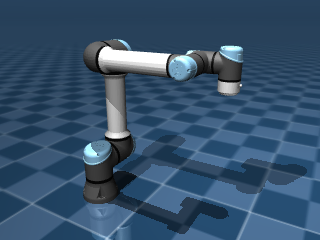
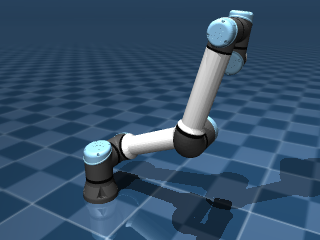

In [8]:
class LevenbegMarquardtIK:
    
    def __init__(self, model, data, step_size, tol, alpha, jacp, jacr, damping):
        self.model = model
        self.data = data
        self.step_size = step_size
        self.tol = tol
        self.alpha = alpha
        self.jacp = jacp
        self.jacr = jacr
        self.damping = damping
    
    def check_joint_limits(self, q):
        """Check if the joints is under or above its limits"""
        for i in range(len(q)):
            q[i] = max(self.model.jnt_range[i][0], min(q[i], self.model.jnt_range[i][1]))

    #Levenberg-Marquardt pseudocode implementation
    def calculate(self, goal, init_q, body_id):
        """Calculate the desire joints angles for goal"""
        self.data.qpos = init_q
        mujoco.mj_forward(self.model, self.data)
        current_pose = self.data.body(body_id).xpos
        error = np.subtract(goal, current_pose)

        while (np.linalg.norm(error) >= self.tol):
            #calculate jacobian
            mujoco.mj_jac(self.model, self.data, self.jacp, self.jacr, goal, body_id)
            #calculate delta of joint q
            n = self.jacp.shape[1]
            I = np.identity(n)
            product = self.jacp.T @ self.jacp + self.damping * I
            
            if np.isclose(np.linalg.det(product), 0):
                j_inv = np.linalg.pinv(product) @ self.jacp.T
            else:
                j_inv = np.linalg.inv(product) @ self.jacp.T
            
            delta_q = j_inv @ error
            #compute next step
            self.data.qpos += self.step_size * delta_q
            #check limits
            self.check_joint_limits(self.data.qpos)
            #compute forward kinematics
            mujoco.mj_forward(self.model, self.data) 
            #calculate new error
            error = np.subtract(goal, self.data.body(body_id).xpos)        

    
#Init variables.
body_id = model.body('wrist_3_link').id
jacp = np.zeros((3, model.nv)) #translation jacobian
jacr = np.zeros((3, model.nv)) #rotational jacobian
goal = [0.49, 0.13, 0.59]
step_size = 0.5
tol = 0.01
alpha = 0.5
init_q = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
damping = 0.15

ik = LevenbegMarquardtIK(model, data, step_size, tol, alpha, jacp, jacr, damping)

#Get desire point
mujoco.mj_resetDataKeyframe(model, data, 1) #reset qpos to initial value
ik.calculate(goal, init_q, body_id) #calculate the qpos

result = data.qpos.copy()

#Plot results
print("Results")
data.qpos = qpos0
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera)
target_plot = renderer.render()

data.qpos = result
mujoco.mj_forward(model, data)
result_point = data.body('wrist_3_link').xpos
renderer.update_scene(data, camera)
result_plot = renderer.render()

print("testing point =>", target)
print("Levenberg-Marquardt result =>", result_point, "\n")

images = {
    'Testing point': target_plot,
    'Levenberg-Marquardt result': result_plot,
}

media.show_images(images)

## Simulation

In [9]:
#Video Setup
DURATION = 4 #(seconds)
FRAMERATE = 60 #(Hz)
frames = []

#Reset state and time.
mujoco.mj_resetData(model, data)

#Init position.
# pi = np.pi
# data.qpos = [3*pi/2, -pi/2, pi/2, 3*pi/2, 3*pi/2, 0] #ENABLE if you want test circle

#Init parameters
jacp = np.zeros((3, model.nv)) #translation jacobian
jacr = np.zeros((3, model.nv)) #rotational jacobian
step_size = 0.5
tol = 0.01
alpha = 0.5
damping = 0.15

#Get error.
end_effector_id = model.body('wrist_3_link').id #"End-effector we wish to control.
current_pose = data.body(end_effector_id).xpos #Current pose

goal = [0.49, 0.13, 0.59] #Desire position

error = np.subtract(goal, current_pose) #Init Error

def check_joint_limits(q):
    """Check if the joints is under or above its limits"""
    for i in range(len(q)):
        q[i] = max(model.jnt_range[i][0], min(q[i], model.jnt_range[i][1]))

def circle(t: float, r: float, h: float, k: float, f: float) -> np.ndarray:
    """Return the (x, y) coordinates of a circle with radius r centered at (h, k)
    as a function of time t and frequency f."""
    x = r * np.cos(2 * np.pi * f * t) + h
    y = r * np.sin(2 * np.pi * f * t) + k
    z = 0.5
    return np.array([x, y, z])

#Simulate
while data.time < DURATION:
    
    # goal = circle(data.time, 0.1, 0.5, 0.0, 0.5) #ENABLE to test circle.
    
    if (np.linalg.norm(error) >= tol):
        #Calculate jacobian
        mujoco.mj_jac(model, data, jacp, jacr, goal, end_effector_id)
        #Calculate delta of joint q
        n = jacp.shape[1]
        I = np.identity(n)
        product = jacp.T @ jacp + damping * I

        if np.isclose(np.linalg.det(product), 0):
            j_inv = np.linalg.pinv(product) @ jacp.T
        else:
            j_inv = np.linalg.inv(product) @ jacp.T

        delta_q = j_inv @ error

        #Compute next step
        q = data.qpos.copy()
        q += step_size * delta_q
        
        #Check limits
        check_joint_limits(data.qpos)
        
        #Set control signal
        data.ctrl = q 
        #Step the simulation.
        mujoco.mj_step(model, data)

        error = np.subtract(goal, data.body(end_effector_id).xpos)
    
    #Render and save frames.
    if len(frames) < data.time * FRAMERATE:
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)
        
#Display video.
media.show_video(frames, fps=FRAMERATE)